In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb

# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

# Handle missing values
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

# Combine 'prompt' and 'answer' columns
train_texts = train_df['prompt'] + " " + train_df['answer']
test_texts = test_df['prompt'] + " " + test_df['answer']

# Fit the vectorizer on training data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Labels
y_train = train_df['AI']
mode_label = y_train.mode()[0]
y_train.replace('', mode_label, inplace=True)

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train)

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13880\2028171845.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.fillna('', inplace=True)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       105
           1       0.50      0.04      0.08        45

    accuracy                           0.70       150
   macro avg       0.60      0.51      0.45       150
weighted avg       0.64      0.70      0.60       150



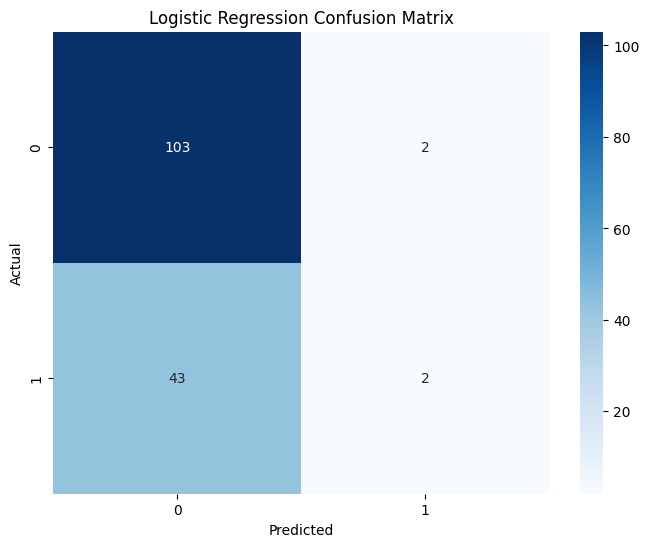

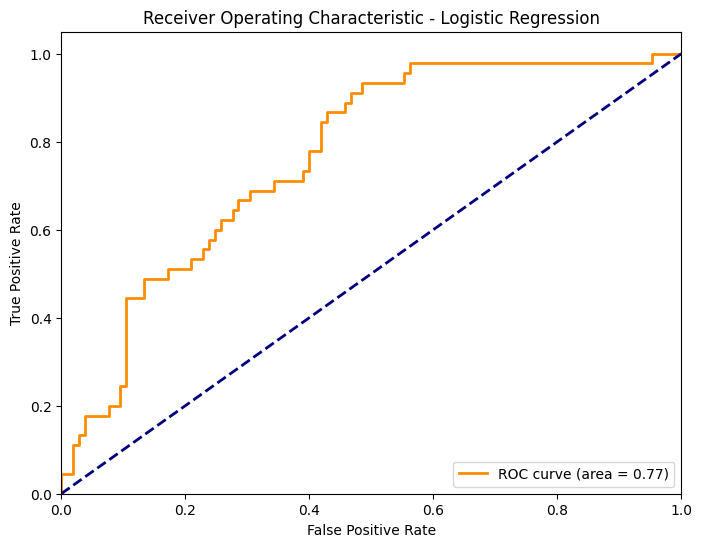

In [3]:
# Logistic Regression Model
model_lr = LogisticRegression()
model_lr.fit(X_train_split, y_train_split)
y_val_pred_lr = model_lr.predict(X_val_split)
print("Logistic Regression Classification Report:")
print(classification_report(y_val_split, y_val_pred_lr))

# Confusion Matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_val_split, y_val_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# ROC Curve for Logistic Regression
y_val_prob_lr = model_lr.predict_proba(X_val_split)[:, 1]
fpr, tpr, _ = roc_curve(y_val_split, y_val_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6591 - loss: 0.6580 - val_accuracy: 0.7000 - val_loss: 0.6103
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7062 - loss: 0.5653 - val_accuracy: 0.7000 - val_loss: 0.5731
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7351 - loss: 0.4305 - val_accuracy: 0.7000 - val_loss: 0.5312
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7368 - loss: 0.3406 - val_accuracy: 0.7333 - val_loss: 0.5593
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9234 - loss: 0.2296 - val_accuracy: 0.7800 - val_loss: 0.5346
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9699 - loss: 0.1498 - val_accuracy: 0.7933 - val_loss: 0.6209
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9700 - loss: 0.0870 - val_accuracy: 0.8000 - val_loss: 0.7262
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9857 - loss: 0.0548 - val_accuracy: 0.7933 - v

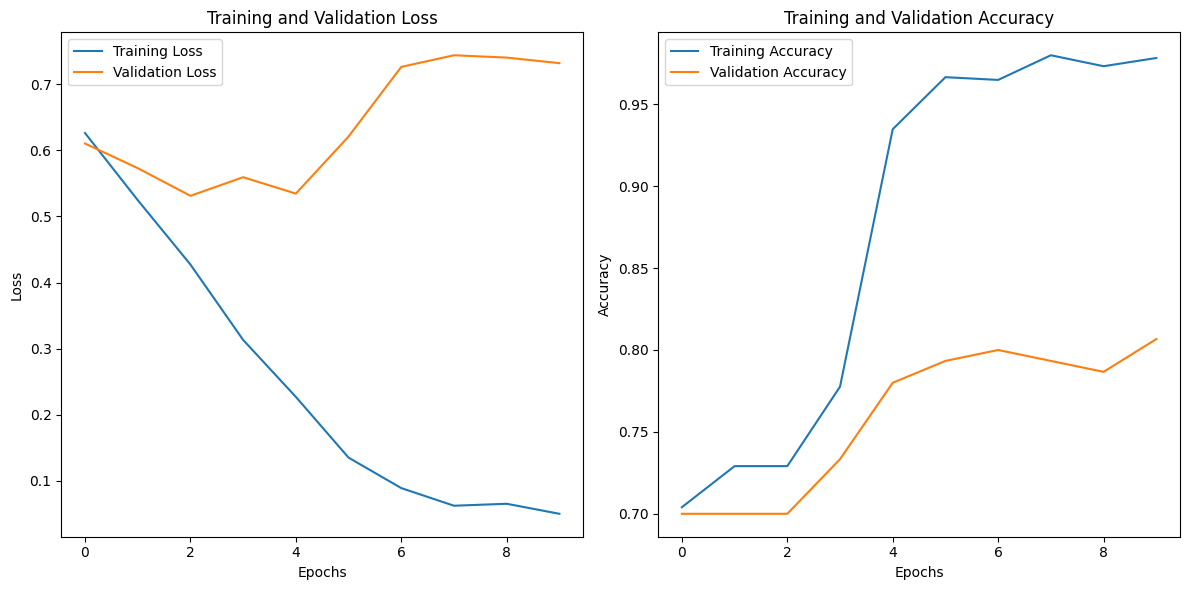

In [4]:
# Define the neural network architecture
model_nn = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_split.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network model
history = model_nn.fit(X_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(X_val_split, y_val_split))

# Evaluate the neural network model
val_loss, val_accuracy = model_nn.evaluate(X_val_split, y_val_split)
print(f'neural network validation Loss: {val_loss}')
print(f'neural network validation Accuracy: {val_accuracy}')

# Predict on the validation set with the neural network
y_val_pred_nn = model_nn.predict(X_val_split)
y_val_pred_nn = (y_val_pred_nn > 0.5).astype(int)
print("Neural Network Classification Report:")
print(classification_report(y_val_split, y_val_pred_nn))

# Training History Plot for Neural Network
history_dict = history.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       105
           1       0.67      0.73      0.70        45

    accuracy                           0.81       150
   macro avg       0.78      0.79      0.78       150
weighted avg       0.82      0.81      0.82       150



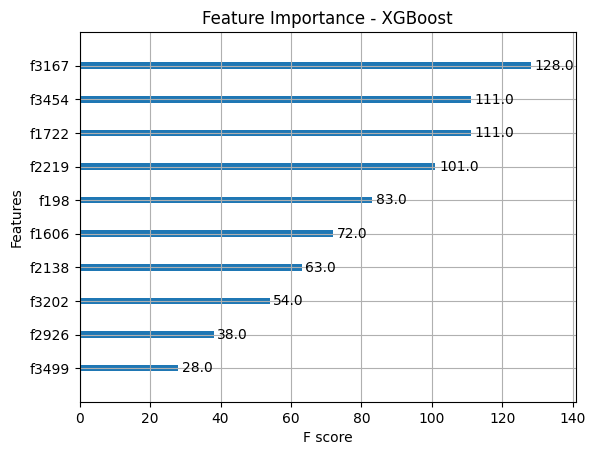

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [5]:
# XGBoost Model
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_split, y_train_split)
y_val_pred_xgb = model_xgb.predict(X_val_split)
print("XGBoost Classification Report:")
print(classification_report(y_val_split, y_val_pred_xgb))

# Feature Importance Plot for XGBoost
xgb.plot_importance(model_xgb, max_num_features=10, importance_type='weight')
plt.title('Feature Importance - XGBoost')
plt.show()

# Test data preprocessing
X_test = vectorizer.transform(test_texts).toarray()

# Logistic Regression Predictions
y_test_pred_lr = model_lr.predict(X_test)

# Neural Network Predictions
y_test_pred_nn = model_nn.predict(X_test)
y_test_pred_nn = (y_test_pred_nn > 0.5).astype(int)

# XGBoost Predictions
y_test_pred_xgb = model_xgb.predict(X_test)

# Create a copy of the submission dataframe for each model's predictions
submission_lr = submission_df.copy()
submission_nn = submission_df.copy()
submission_xgb = submission_df.copy()

# Assign predictions to each copy
submission_lr['AI'] = y_test_pred_lr
submission_nn['AI'] = y_test_pred_nn
submission_xgb['AI'] = y_test_pred_xgb

# Save each to a separate CSV file
submission_lr.to_csv('completed_submission_lr.csv', index=False)
submission_nn.to_csv('completed_submission_nn.csv', index=False)
submission_xgb.to_csv('completed_submission_xgb.csv', index=False)